# Fraud Detection Model

This notebook loads the Rotterdam benefits fraud investigation data, preprocesses it, and trains a Decision Tree model to predict the `checked` status.

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.executable)


/Users/dimanavihrenova/Desktop/testing-ai/.venv/bin/python


## 1. Data Loading

In [3]:
# Load the dataset
df = pd.read_csv('../data/investigation_train_large_checked.csv')

# Display basic info and first few rows
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Columns: 318 entries, adres_aantal_brp_adres to checked
dtypes: bool(1), float64(2), int64(315)
memory usage: 314.5 MB
None


,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


## 2. Preprocessing

In [4]:
# Drop 'Ja' and 'Nee' columns if they exist (potential data leakage)
cols_to_drop = [col for col in ['Ja', 'Nee'] if col in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"Dropped columns: {cols_to_drop}")

# Convert 'checked' target column to integer (0/1)
if df['checked'].dtype == 'bool' or df['checked'].dtype == 'object':
    df['checked'] = df['checked'].astype(int)

print("Target distribution:")
print(df['checked'].value_counts())

Dropped columns: ['Ja', 'Nee']
Target distribution:
checked
0    110496
1     19504
Name: count, dtype: int64


In [5]:
proxy_vars = [
    # Neighbourhood
    "adres_recentste_buurt_groot_ijsselmonde",
    "adres_recentste_buurt_nieuwe_westen",
    "adres_recentste_buurt_other",
    "adres_recentste_buurt_oude_noorden",
    "adres_recentste_buurt_vreewijk",
    "adres_aantal_verschillende_wijken",

    # Language-related proxies
    "belemmering_hist_taal",
    "contacten_onderwerp_beoordelen_taaleis",
    "contacten_onderwerp_boolean_beoordelen_taaleis",
    "contacten_onderwerp_boolean_taaleis___voldoet",
    "persoonlijke_eigenschappen_dagen_sinds_taaleis",
    "persoonlijke_eigenschappen_spreektaal",
    "persoonlijke_eigenschappen_spreektaal_anders",
    "persoonlijke_eigenschappen_taaleis_schrijfv_ok",
    "persoonlijke_eigenschappen_taaleis_voldaan"
]


## 3. Modeling

In [6]:
# Check Class Balance
print("Class distribution:")
print(df['checked'].value_counts(normalize=True))

Class distribution:
checked
0    0.849969
1    0.150031
Name: proportion, dtype: float64


In [7]:
# -------------------------------
# GOOD MODEL DATA: remove proxy variables
# -------------------------------
X_good = df.drop(columns=['checked'] + proxy_vars, errors='ignore')
y_good = df['checked']

# -------------------------------
# BAD MODEL DATA: keep proxies + bias the sample
# -------------------------------
# Define a "risk" group based on language barrier and specific neighbourhoods
mask_risk = (
    (df["belemmering_hist_taal"] == 1) |
    (df["adres_recentste_buurt_groot_ijsselmonde"] == 1) |
    (df["adres_recentste_buurt_oude_noorden"] == 1)
)

df_risk = df[mask_risk]
df_nonrisk = df[~mask_risk]

# Oversample risk group, undersample others -> intentionally biased training data
df_bad = pd.concat([
    df_risk.sample(frac=3, replace=True, random_state=42),
    df_nonrisk.sample(frac=0.5, random_state=42)
])

X_bad = df_bad.drop(columns=['checked'])
y_bad = df_bad['checked']

# -------------------------------
# Train/test splits for both models
# -------------------------------
from sklearn.model_selection import train_test_split

# Good (de-biased) model
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_good, y_good, test_size=0.2, random_state=42, stratify=y_good
)

# Bad (biased) model
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bad, y_bad, test_size=0.2, random_state=42, stratify=y_bad
)

print(f"GOOD model - training set shape: {Xg_train.shape}, test set shape: {Xg_test.shape}")
print(f"BAD model  - training set shape: {Xb_train.shape}, test set shape: {Xb_test.shape}")


GOOD model - training set shape: (104000, 300), test set shape: (26000, 300)
BAD model  - training set shape: (72672, 315), test set shape: (18168, 315)


In [8]:
# =====================================
# GOOD MODEL: preprocess + SMOTE
# =====================================
Xg_train_proc = np.nan_to_num(Xg_train, nan=0, posinf=1e9, neginf=-1e9)
Xg_test_proc  = np.nan_to_num(Xg_test,  nan=0, posinf=1e9, neginf=-1e9)

scaler_good = StandardScaler()
Xg_train_scaled = scaler_good.fit_transform(Xg_train_proc)
Xg_test_scaled  = scaler_good.transform(Xg_test_proc)

sm_good = SMOTE(random_state=42)
Xg_res, yg_res = sm_good.fit_resample(Xg_train_scaled, yg_train)

# =====================================
# BAD MODEL: preprocess + SMOTE
# =====================================
Xb_train_proc = np.nan_to_num(Xb_train, nan=0, posinf=1e9, neginf=-1e9)
Xb_test_proc  = np.nan_to_num(Xb_test,  nan=0, posinf=1e9, neginf=-1e9)

scaler_bad = StandardScaler()
Xb_train_scaled = scaler_bad.fit_transform(Xb_train_proc)
Xb_test_scaled  = scaler_bad.transform(Xb_test_proc)

sm_bad = SMOTE(random_state=42)
Xb_res, yb_res = sm_bad.fit_resample(Xb_train_scaled, yb_train)


In [9]:
# GOOD model (de-biased)
clf_good = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
clf_good.fit(Xg_res, yg_res)

# BAD model (biased)
clf_bad = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
clf_bad.fit(Xb_res, yb_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 4. Evaluation

=== GOOD MODEL (de-biased) ===
Accuracy:   0.8930
ROC AUC:    0.9391

Classification Report (GOOD):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     22099
           1       0.92      0.31      0.47      3901

    accuracy                           0.89     26000
   macro avg       0.91      0.65      0.70     26000
weighted avg       0.90      0.89      0.87     26000



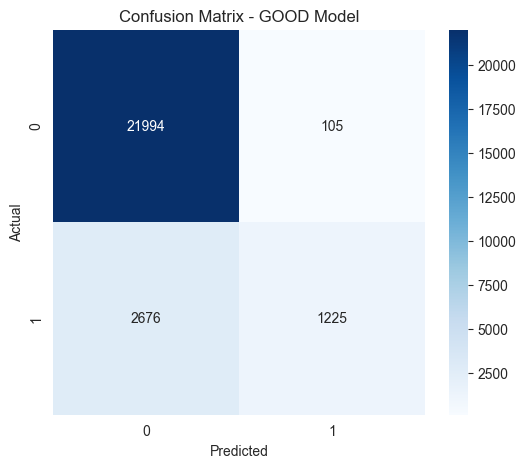



=== BAD MODEL (biased) ===
Accuracy:   0.9224
ROC AUC:    0.9680

Classification Report (BAD):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     15498
           1       0.97      0.49      0.65      2670

    accuracy                           0.92     18168
   macro avg       0.94      0.74      0.80     18168
weighted avg       0.93      0.92      0.91     18168



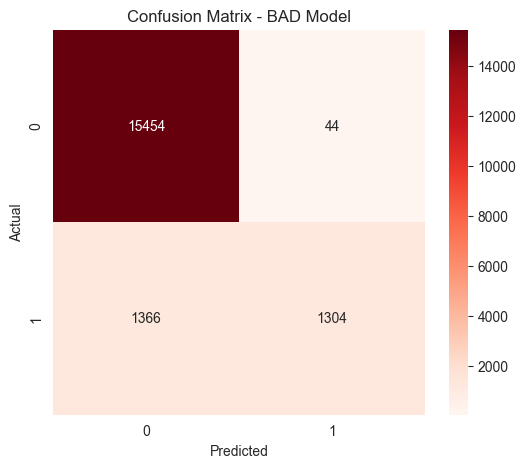

In [10]:
# ==========================
# GOOD model evaluation
# ==========================
y_proba_good = clf_good.predict_proba(Xg_test_scaled)[:, 1]
y_pred_good = clf_good.predict(Xg_test_scaled)   # default 0.5 threshold

accuracy_good = accuracy_score(yg_test, y_pred_good)
roc_auc_good = roc_auc_score(yg_test, y_proba_good)

print("=== GOOD MODEL (de-biased) ===")
print(f"Accuracy:   {accuracy_good:.4f}")
print(f"ROC AUC:    {roc_auc_good:.4f}")

print("\nClassification Report (GOOD):")
print(classification_report(yg_test, y_pred_good))

cm_good = confusion_matrix(yg_test, y_pred_good)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_good, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GOOD Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ==========================
# BAD model evaluation
# ==========================
y_proba_bad = clf_bad.predict_proba(Xb_test_scaled)[:, 1]
y_pred_bad = clf_bad.predict(Xb_test_scaled)     # default 0.5 threshold

accuracy_bad = accuracy_score(yb_test, y_pred_bad)
roc_auc_bad = roc_auc_score(yb_test, y_proba_bad)

print("\n\n=== BAD MODEL (biased) ===")
print(f"Accuracy:   {accuracy_bad:.4f}")
print(f"ROC AUC:    {roc_auc_bad:.4f}")

print("\nClassification Report (BAD):")
print(classification_report(yb_test, y_pred_bad))

cm_bad = confusion_matrix(yb_test, y_pred_bad)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bad, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - BAD Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

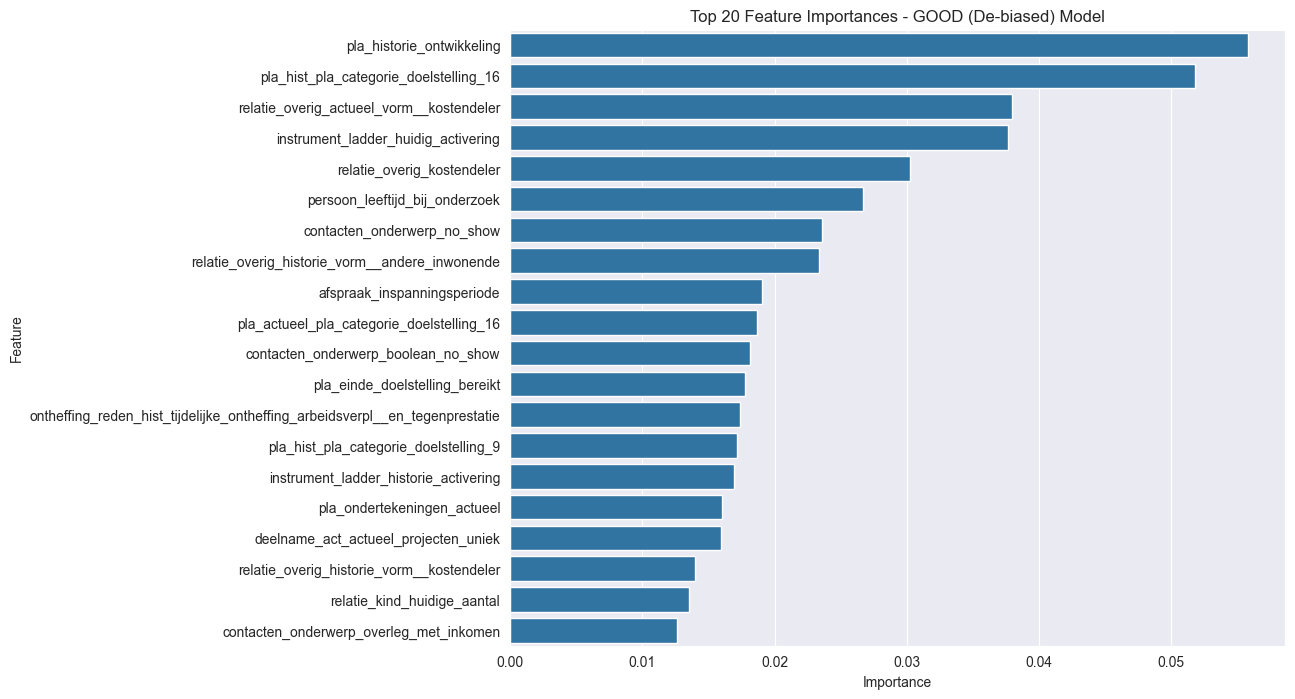

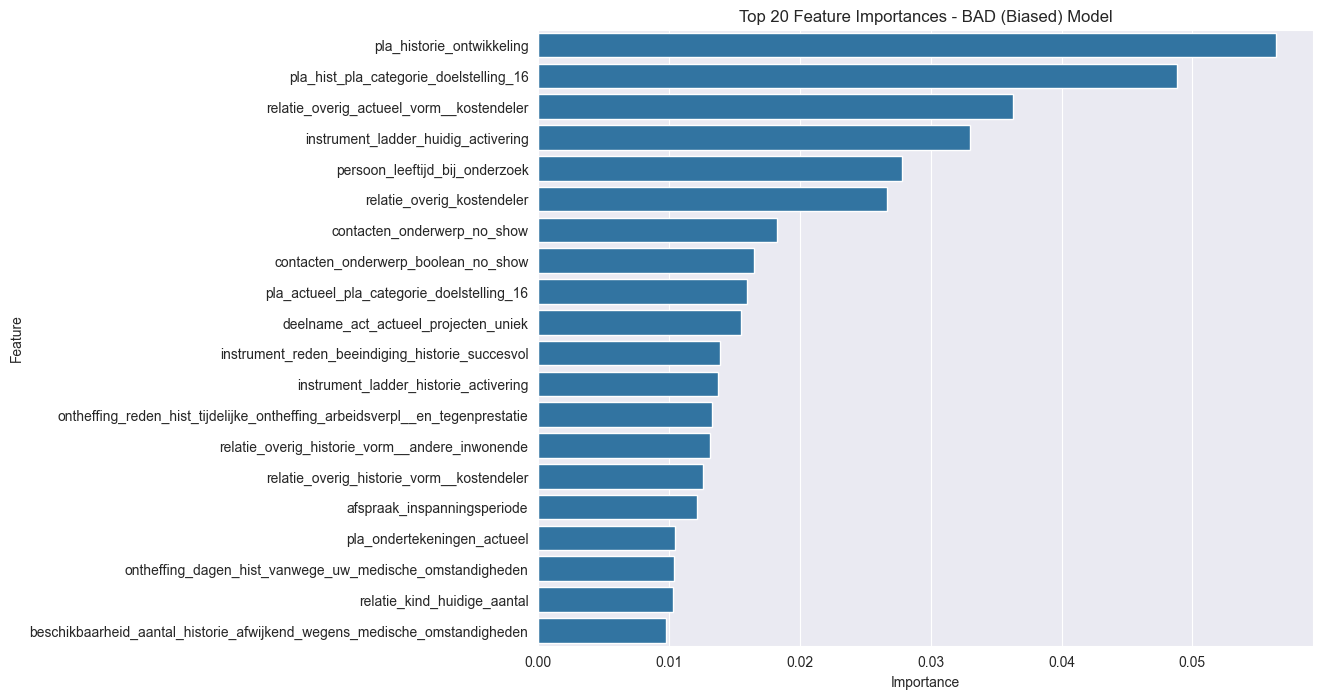

In [11]:
# ==========================
# Feature Importances - GOOD MODEL
# ==========================
importances_good = clf_good.feature_importances_
feature_names_good = X_good.columns  # correct feature set (no proxies)
feature_imp_good = pd.DataFrame({'Feature': feature_names_good, 'Importance': importances_good})
feature_imp_good = feature_imp_good.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_good)
plt.title('Top 20 Feature Importances - GOOD (De-biased) Model')
plt.show()


# ==========================
# Feature Importances - BAD MODEL
# ==========================
importances_bad = clf_bad.feature_importances_
feature_names_bad = X_bad.columns  # includes proxy variables
feature_imp_bad = pd.DataFrame({'Feature': feature_names_bad, 'Importance': importances_bad})
feature_imp_bad = feature_imp_bad.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_bad)
plt.title('Top 20 Feature Importances - BAD (Biased) Model')
plt.show()


## 5. ONNX export



In [12]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import random

# Convert both classifiers to ONNX
onnx_good = convert_sklearn(
    clf_good,
    initial_types=[("input", FloatTensorType([None, Xg_train_scaled.shape[1]]))]
)

onnx_bad = convert_sklearn(
    clf_bad,
    initial_types=[("input", FloatTensorType([None, Xb_train_scaled.shape[1]]))]
)

# Randomly assign them to model_1.onnx and model_2.onnx
models = [("good", onnx_good), ("bad", onnx_bad)]
random.shuffle(models)

for i, (name, onnx_model) in enumerate(models, start=1):
    filename = f"model_{i}.onnx"
    with open(filename, "wb") as f:
        f.write(onnx_model.SerializeToString())
    print(f"Saved {filename}  (this one is the {name.upper()} model)")


Saved model_1.onnx  (this one is the GOOD model)
Saved model_2.onnx  (this one is the BAD model)
